In [23]:
%reload_ext autoreload
%autoreload 2

In [24]:
from dc_main import DCTrader

AAPL: 1341 días cargados | 2020-01-02 → 2025-05-02


C:\GitHub\CEIA\MSTGAM-4trading\src\dc_main.py:41: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  dates = self.data['Date'].dt.to_pydatetime()  # Convertir a datetime.datetime para .days


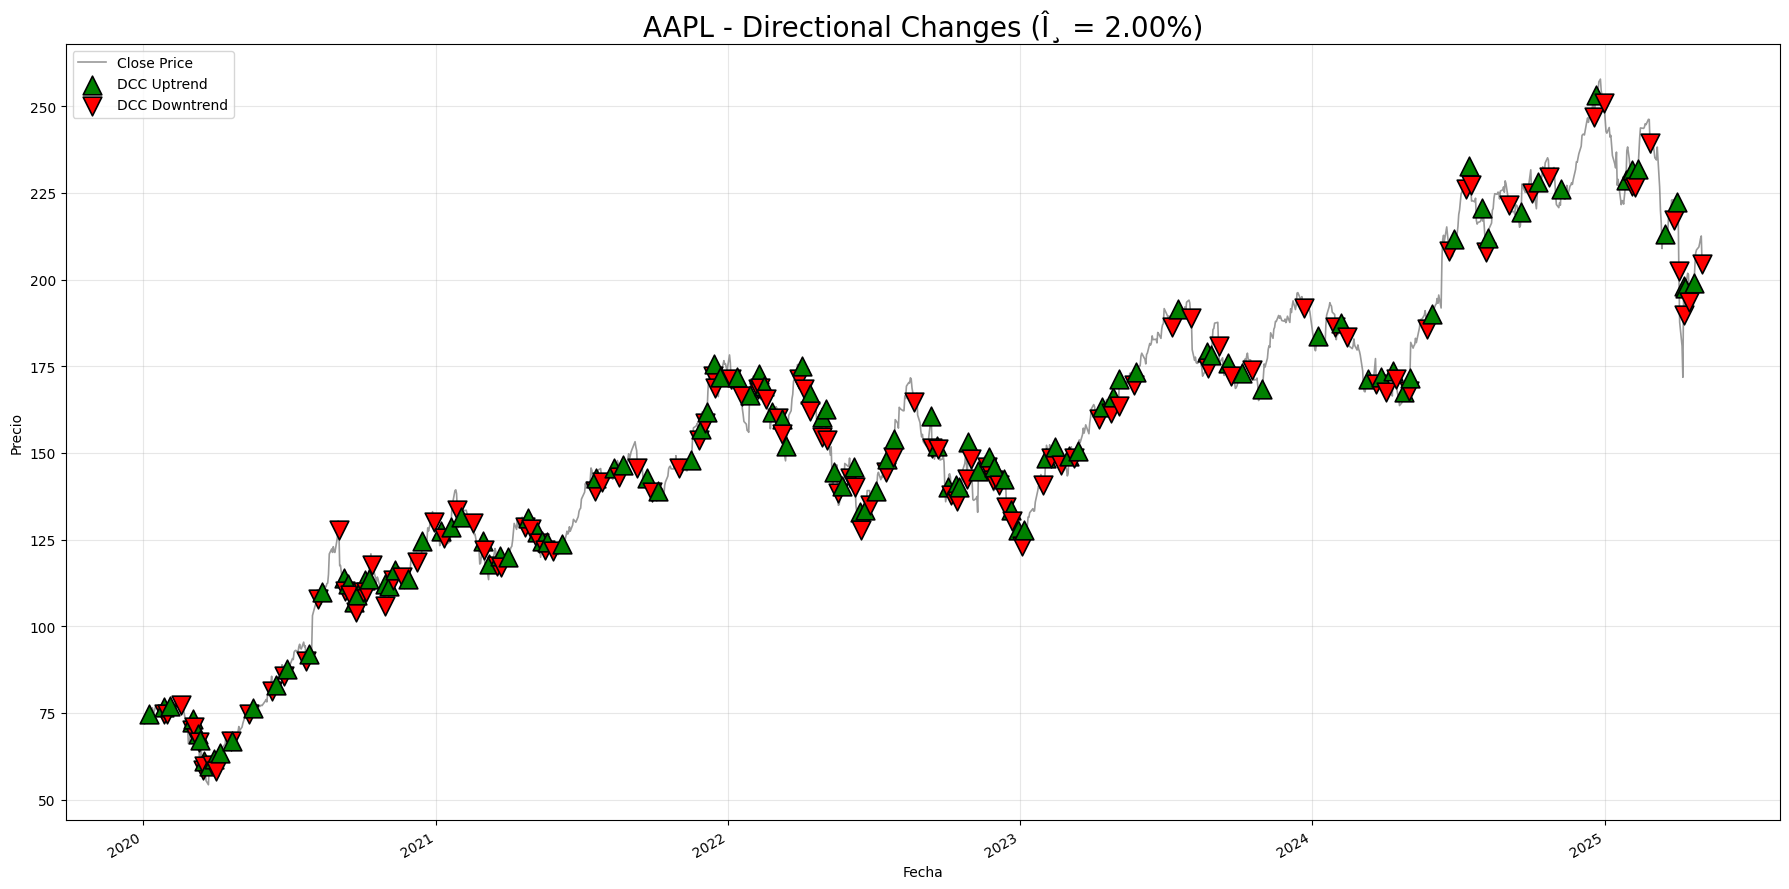

In [25]:
ticker = 'AAPL'
trader = DCTrader(ticker)
trader.thresholds = [0.00098, 0.0022, 0.0048, 0.0072, 0.0098,
                    0.0122, 0.0155, 0.0170, 0.0200, 0.0255
                    ]               
trader.load_data(start_date='2020-01-01', end_date='2025-05-05')
trader.plot_dc(theta=0.02)